## Overview

In this tutorial, we will build a simple aritificial neural network (ANN), also known as multilayer perceptron (MLP) or feedforward neural network (FNN). The learning outcomes are:
1. Understand how the model is formulated mathematically;
2. Understand what is meant by training the network;
3. Experiment with more complex architectures.

## Data

We generate data from a Gaussian process with a specified covariance matrix. The details of data generation do not matter as in reality, you never know the actual data generation machanism.

**The key** here is that we want to predict $y \in R^5$ given the previous values $x\in R^{25}$.

In [4]:
import numpy as np
import sys
import os
sys.path.insert(1, '..')
os.chdir('..')

from data_formatters.dubosson2018 import *
from dataset import TSDataset
from conf import Conf

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from models.mlp import MLP
from models.lstm import LSTM_SeqtoSeq

# load config file
cnf = Conf(conf_file_path='./conf/dubosson.yaml', seed=15, exp_name="DUBOSSON", log=False)
data_formatter = DubossonFormatter(cnf)

# set up torch datasets: train, val, test
train_dataset = TSDataset(cnf, data_formatter, data_formatter.train_data)
val_dataset = TSDataset(cnf, data_formatter, data_formatter.val_data)
test_dataset = TSDataset(cnf, data_formatter, data_formatter.test_data)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Dropped segments: 0
Extracted segments: 9
Getting valid sampling locations.
# available segments=3539
Extracting all available segments.
1000 of 3539 samples done...
2000 of 3539 samples done...
3000 of 3539 samples done...
Getting valid sampling locations.
# available segments=7
Extracting all available segments.
Getting valid sampling locations.
# available segments=7
Extracting all available segments.


## Linear regression

Suppose we want to model our data as a linear transformation, that is we aim to find $W \in R^{25\times 5}$ so that to minimize the squared error between the prediction and the truth. In summary, we formulate the problem as:
$$
W^* = \argmin_{W} || Y -  XW ||^2
$$

This model is an extension of the model many of us have covered in the introductory statisics courses to a multivariate case. **Recall** that for one-dimensional case (i.e. when $y \in R$) and under some distributional assumptions, this optimization problem has a closed form solution that is guaranteed to be the best (BLUE). When we move to more dimensions and start relaxing the assumptions, we no longer have the closed-form solution. Hence, we need to resort to the apprximate methods. Below, we program the model and see its performance.

In [2]:
import torch
class LinearModel(torch.nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear_collapse = torch.nn.Linear(6, 1)
        self.linear = torch.nn.Linear(192, 24)
        
    def forward(self, x):
        y_pred = self.linear(torch.squeeze(self.linear_collapse(x)))
        return y_pred

In [6]:
# train model
best_loss = 1e10
model = LinearModel()
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
for epoch in range(100):
    for i, d in enumerate(train_loader):
        # Forward pass
        outputs = model(d.get('inputs'))
        loss = criterion(outputs, torch.squeeze(d.get('outputs')))
        
        # Backward and optimize
        optimizer.zero_grad() # zero the gradient buffer
        loss.backward() # compute gradient
        optimizer.step() # update parameters
        
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # validate model
    with torch.no_grad():
        for i, d in enumerate(val_loader):
            outputs = model(d.get('inputs'))
            loss = criterion(outputs, torch.squeeze(d.get('outputs')))
        print ('Epoch [{}/{}], Val Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # save best model based on val loss
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), 'best_model.pth')
# load best model
model.load_state_dict(torch.load('best_model.pth'))
    

Epoch [1/100], Loss: 0.6246
Epoch [1/100], Val Loss: 0.4106
Epoch [2/100], Loss: 0.6812
Epoch [2/100], Val Loss: 0.5315
Epoch [3/100], Loss: 0.6226
Epoch [3/100], Val Loss: 0.5278
Epoch [4/100], Loss: 0.5544
Epoch [4/100], Val Loss: 0.5336
Epoch [5/100], Loss: 0.6072
Epoch [5/100], Val Loss: 0.5160
Epoch [6/100], Loss: 0.4673
Epoch [6/100], Val Loss: 0.4540
Epoch [7/100], Loss: 0.3573
Epoch [7/100], Val Loss: 0.4493
Epoch [8/100], Loss: 0.2638
Epoch [8/100], Val Loss: 0.4107
Epoch [9/100], Loss: 0.3277
Epoch [9/100], Val Loss: 0.3990
Epoch [10/100], Loss: 0.4474
Epoch [10/100], Val Loss: 0.3719
Epoch [11/100], Loss: 0.2803
Epoch [11/100], Val Loss: 0.3653
Epoch [12/100], Loss: 0.5307
Epoch [12/100], Val Loss: 0.3802
Epoch [13/100], Loss: 0.2774
Epoch [13/100], Val Loss: 0.3651
Epoch [14/100], Loss: 0.3424
Epoch [14/100], Val Loss: 0.3647
Epoch [15/100], Loss: 0.2814
Epoch [15/100], Val Loss: 0.3444
Epoch [16/100], Loss: 0.3060
Epoch [16/100], Val Loss: 0.3552
Epoch [17/100], Loss: 0.29

<All keys matched successfully>

In [7]:
# evaluate model on test set
with torch.no_grad():
    for i, d in enumerate(test_loader):
        outputs = model(d['inputs'])
        labels = torch.squeeze(d['outputs'])
        loss = criterion(outputs, labels)
    print ('Epoch [{}/{}], Test Loss: {:.4f}'.format(epoch+1, 100, loss.item()))

Epoch [100/100], Test Loss: 0.2878


IndexError: index 7 is out of bounds for dimension 0 with size 7

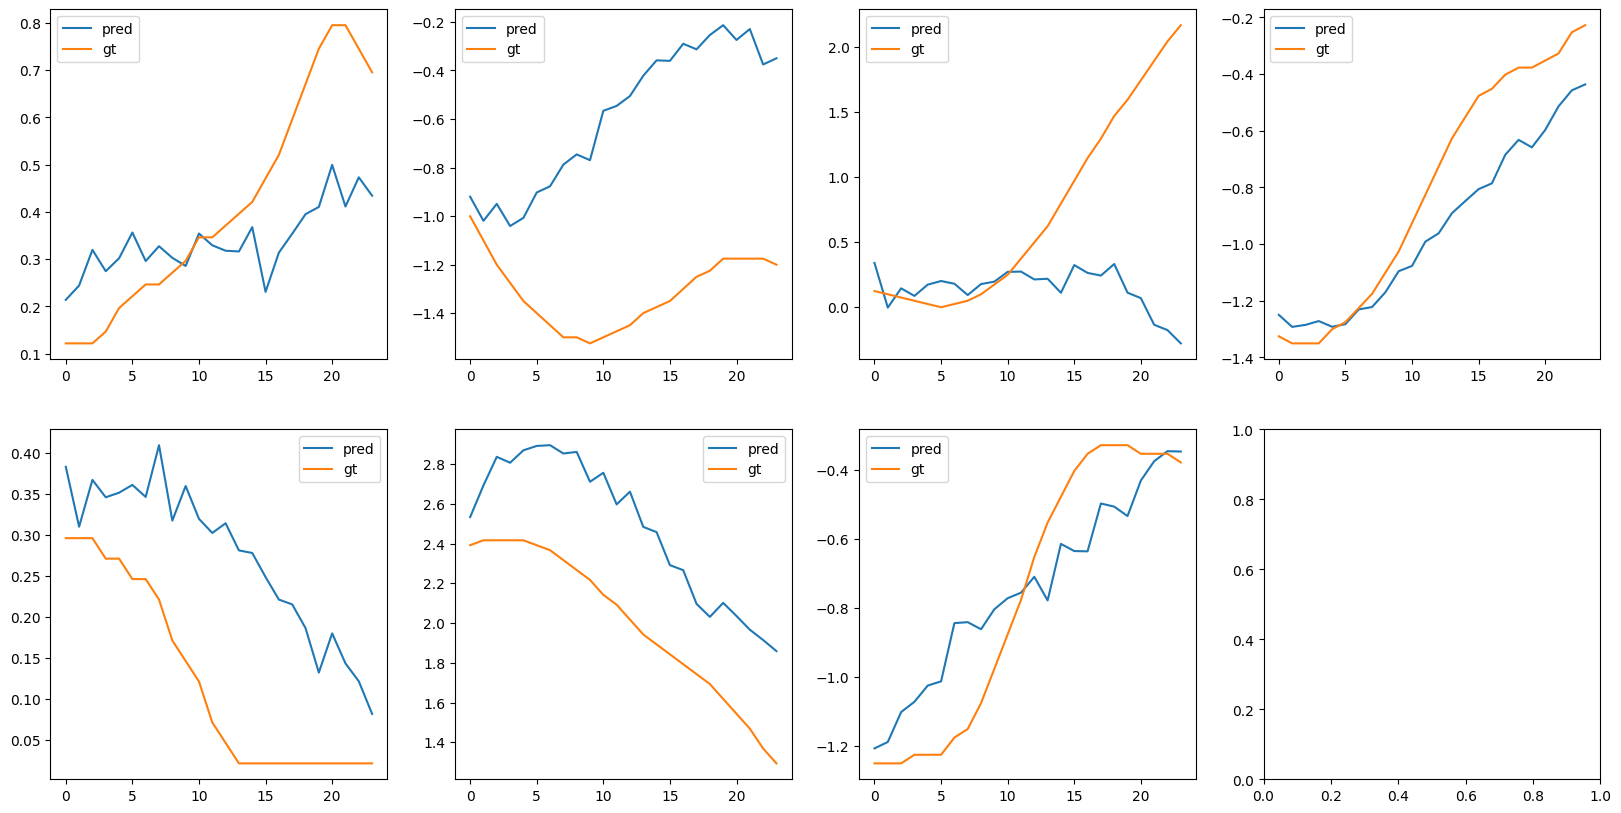

In [8]:
# plots the predictions vs the ground truth
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(2):
    for j in range(4):
        ax[i, j].plot(outputs[i*4+j, :], label='pred')
        ax[i, j].plot(labels[i*4+j, :], label='gt')
        ax[i, j].legend()

## Can we do better?

In our case, there is little justification to move beyond the linear regression setting because of how the data is generated. Nevertheless, nobody is stopping us from trying. Let's now formulate our model as: $$\hat y  = (ReLU(XW^{(1)})) W^{(2)},$$
where $W^{(1)} \in R^{25 \times n_1}, W^{(2)} \in R^{n_1 \times 5}$ are learnable weight matrie and $n_1$ is a hyper-parameter we get to choose.

The main points we want to you to notice from this example are:
1. More complex models do not mean better performance;
2. Hyper-parameter tuning is tedious;
3. **Most importantly**, we can learn any differentiable architecture with the help of SGD.

In [9]:
# # define model
# import torch
# class MLP(torch.nn.Module):
#     def __init__(self, n1):
#         super(MLP, self).__init__()
#         self.linear_collapse = torch.nn.Linear(6, 1)
#         self.linear = torch.nn.Linear(192, n1)
#         self.relu = torch.nn.ReLU()
#         self.linear2 = torch.nn.Linear(n1, 24)
        
#     def forward(self, x):
#         y_pred = self.linear2(self.relu(self.linear(torch.squeeze(self.linear_collapse(x)))))
#         return y_pred

In [22]:
# train model
best_loss = 1e10
model = MLP(192, 6, 24, 36, 3, 0.3)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
for epoch in range(100):
    for i, d in enumerate(train_loader):
        # Forward pass
        outputs = model(d.get('inputs'))
        loss = criterion(outputs, torch.squeeze(d.get('outputs')))
        
        # Backward and optimize
        optimizer.zero_grad() # zero the gradient buffer
        loss.backward() # compute gradient
        optimizer.step() # update parameters
        
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # validate model
    with torch.no_grad():
        for i, d in enumerate(val_loader):
            outputs = model(d.get('inputs'))
            loss = criterion(outputs, torch.squeeze(d.get('outputs')))
        print ('Epoch [{}/{}], Val Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # save best model based on val loss
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), 'best_model.pth')
# load best model
model.load_state_dict(torch.load('best_model.pth'))

Epoch [1/100], Loss: 0.9849
Epoch [1/100], Val Loss: 0.4124
Epoch [2/100], Loss: 0.8952
Epoch [2/100], Val Loss: 0.4102
Epoch [3/100], Loss: 1.5850
Epoch [3/100], Val Loss: 0.4093
Epoch [4/100], Loss: 1.3973
Epoch [4/100], Val Loss: 0.4047
Epoch [5/100], Loss: 0.8706
Epoch [5/100], Val Loss: 0.4123
Epoch [6/100], Loss: 1.0498
Epoch [6/100], Val Loss: 0.4108
Epoch [7/100], Loss: 0.7969
Epoch [7/100], Val Loss: 0.4117
Epoch [8/100], Loss: 0.7169
Epoch [8/100], Val Loss: 0.4106
Epoch [9/100], Loss: 0.6832
Epoch [9/100], Val Loss: 0.4171
Epoch [10/100], Loss: 1.0950
Epoch [10/100], Val Loss: 0.4189
Epoch [11/100], Loss: 0.9343
Epoch [11/100], Val Loss: 0.4212
Epoch [12/100], Loss: 1.4018
Epoch [12/100], Val Loss: 0.4148
Epoch [13/100], Loss: 0.9334
Epoch [13/100], Val Loss: 0.4201
Epoch [14/100], Loss: 0.9236
Epoch [14/100], Val Loss: 0.4220
Epoch [15/100], Loss: 0.7135
Epoch [15/100], Val Loss: 0.4206
Epoch [16/100], Loss: 1.3123
Epoch [16/100], Val Loss: 0.4232
Epoch [17/100], Loss: 1.22

<All keys matched successfully>

In [23]:
# evaluate model on test set
with torch.no_grad():
    #for i, (inputs, labels) in enumerate(test_loader):
    for i, d in enumerate(test_loader):
        outputs = model(d['inputs'])
        labels = torch.squeeze(d['outputs'])
        loss = criterion(outputs, labels)
    print ('Epoch [{}/{}], Test Loss: {:.4f}'.format(epoch+1, 100, loss.item()))

Epoch [100/100], Test Loss: 0.4995


IndexError: index 7 is out of bounds for dimension 0 with size 7

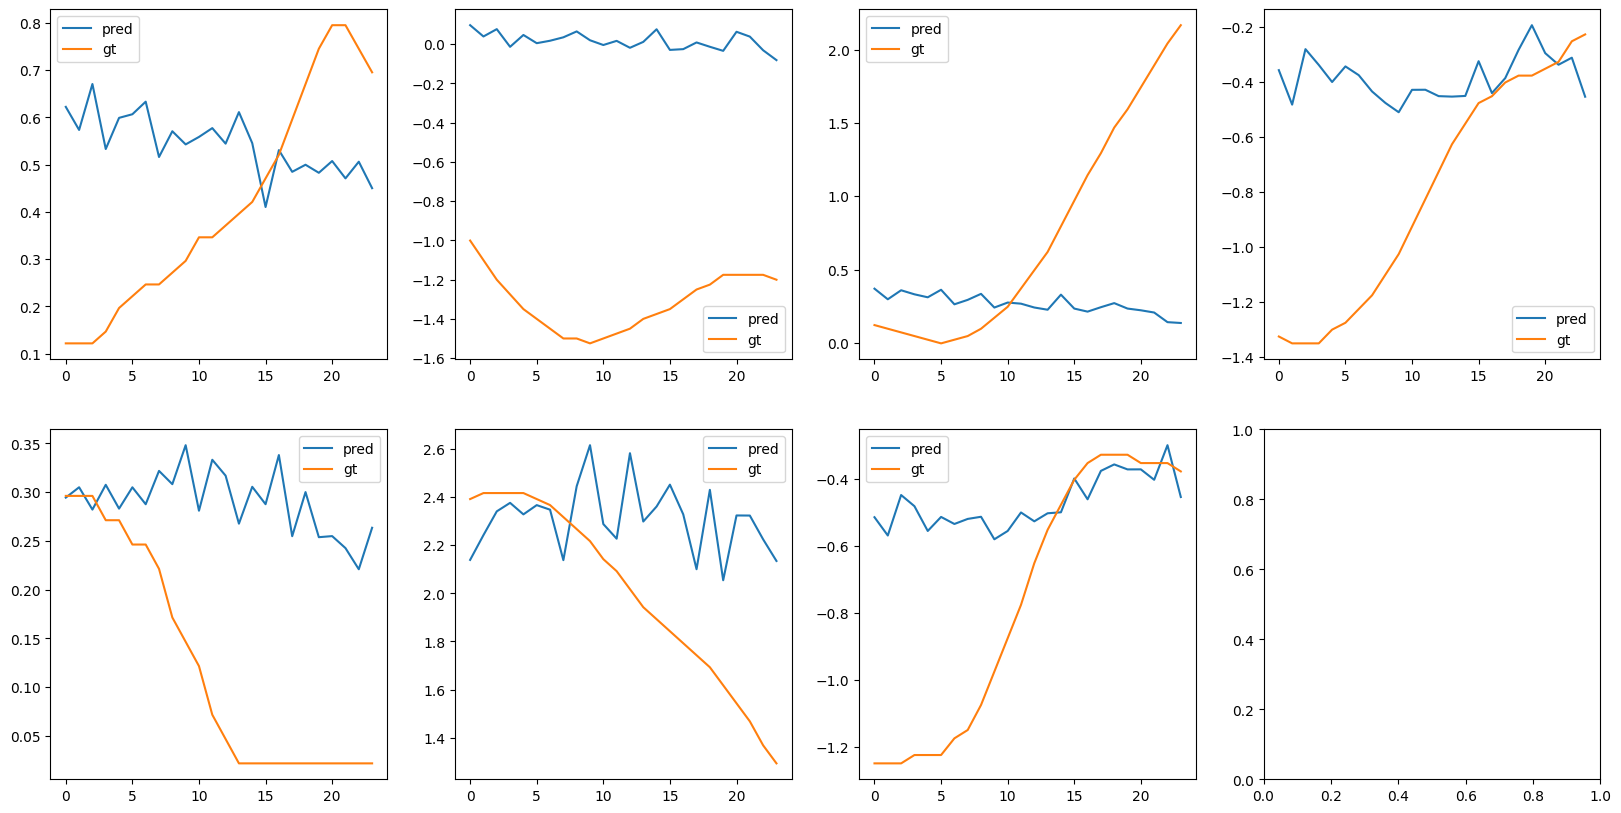

In [24]:
# plots the predictions vs the ground truth
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(2):
    for j in range(4):
        ax[i, j].plot(outputs[i*4+j, :], label='pred')
        ax[i, j].plot(labels[i*4+j, :], label='gt')
        ax[i, j].legend()

## LSTM
Training an LSTM model  

In [7]:
# train model
best_loss = 1e10
model = LSTM_SeqtoSeq(192, 6, 24, 6)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
for epoch in range(100):
    for i, d in enumerate(train_loader):
        # Forward pass
        outputs = model(d.get('inputs'))
        loss = criterion(outputs[1], d.get('outputs'))
        
        # Backward and optimize
        optimizer.zero_grad() # zero the gradient buffer
        loss.backward() # compute gradient
        optimizer.step() # update parameters
        
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # validate model
    with torch.no_grad():
        for i, d in enumerate(val_loader):
            outputs = model(d.get('inputs'))
            loss = criterion(outputs[1], d.get('outputs'))
        print ('Epoch [{}/{}], Val Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # save best model based on val loss
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), 'best_model.pth')
# load best model
model.load_state_dict(torch.load('best_model.pth'))

Epoch [1/100], Loss: 0.8018
Epoch [1/100], Val Loss: 0.4108
Epoch [2/100], Loss: 0.7941
Epoch [2/100], Val Loss: 0.4121
Epoch [3/100], Loss: 0.7939
Epoch [3/100], Val Loss: 0.4125
Epoch [4/100], Loss: 0.7937
Epoch [4/100], Val Loss: 0.4128
Epoch [5/100], Loss: 0.7935
Epoch [5/100], Val Loss: 0.4131
Epoch [6/100], Loss: 0.7934
Epoch [6/100], Val Loss: 0.4134
Epoch [7/100], Loss: 0.7932
Epoch [7/100], Val Loss: 0.4136
Epoch [8/100], Loss: 0.7931
Epoch [8/100], Val Loss: 0.4138
Epoch [9/100], Loss: 0.7930
Epoch [9/100], Val Loss: 0.4140
Epoch [10/100], Loss: 0.7929
Epoch [10/100], Val Loss: 0.4141
Epoch [11/100], Loss: 0.7927
Epoch [11/100], Val Loss: 0.4142
Epoch [12/100], Loss: 0.7926
Epoch [12/100], Val Loss: 0.4143
Epoch [13/100], Loss: 0.7924
Epoch [13/100], Val Loss: 0.4144
Epoch [14/100], Loss: 0.7923
Epoch [14/100], Val Loss: 0.4145
Epoch [15/100], Loss: 0.7921
Epoch [15/100], Val Loss: 0.4146
Epoch [16/100], Loss: 0.7918
Epoch [16/100], Val Loss: 0.4146
Epoch [17/100], Loss: 0.79

<All keys matched successfully>

In [12]:
# evaluate model on test set
with torch.no_grad():
    #for i, (inputs, labels) in enumerate(test_loader):
    for i, d in enumerate(test_loader):
        outputs = model(d['inputs'])
        labels = d['outputs']
        loss = criterion(outputs[1], labels)
    print ('Epoch [{}/{}], Test Loss: {:.4f}'.format(epoch+1, 100, loss.item()))

Epoch [100/100], Test Loss: 1.2486


IndexError: index 7 is out of bounds for dimension 0 with size 7

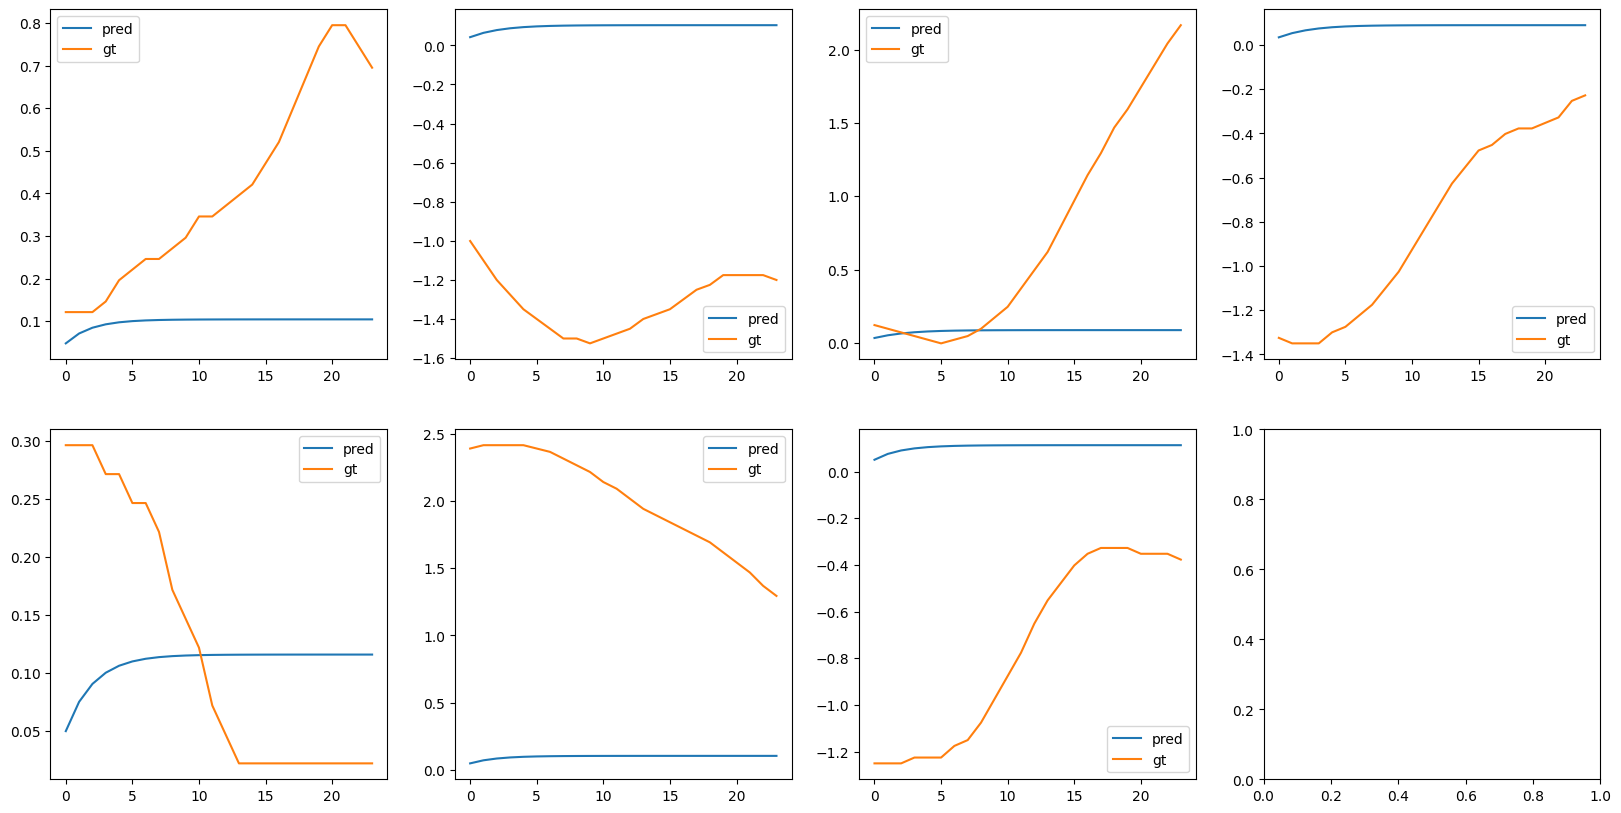

In [14]:
# plots the predictions vs the ground truth
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(2):
    for j in range(4):
        ax[i, j].plot(outputs[1][i*4+j, :], label='pred')
        ax[i, j].plot(labels[i*4+j, :], label='gt')
        ax[i, j].legend()